# CPSC 330 - Applied Machine Learning 

## Homework 6: Putting it all together 
### Associated lectures: All material till lecture 13 

**Due date: Monday, November 15, 2021 at 11:59pm**

## Table of contents

- [Submission instructions](#si)
- [Understanding the problem](#1)
- [Data splitting](#2)
- [EDA](#3)
- (Optional) [Feature engineering](#4)
- [Preprocessing and transformations](#5)
- [Baseline model](#6)
- [Linear models](#7)
- [Different classifiers](#8)
- (Optional) [Feature selection](#9)
- [Hyperparameter optimization](#10)
- [Interpretation and feature importances](#11)
- [Results on the test set](#12)
- (Optional) [Explaining predictions](#13)
- [Summary of the results](#14)

## Imports 

In [1]:
# import sys
# !conda install --yes --prefix {sys.prefix} eli5
# !conda install -c conda-forge eli5

In [2]:
import os

%matplotlib inline
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    plot_confusion_matrix,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC

<br><br>

## Instructions 
<hr>
rubric={points:2}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330/blob/master/docs/homework_instructions.md). 

**You may work on this homework in a group and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 3. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

<br><br>

## Introduction <a name="in"></a>
<hr>

At this point we are at the end of supervised machine learning part of the course. So in this homework, you will be working on an open-ended mini-project, where you will put all the different things you have learned so far together to solve an interesting problem.

A few notes and tips when you work on this mini-project: 

#### Tips

1. This mini-project is open-ended, and while working on it, there might be some situations where you'll have to use your own judgment and make your own decisions (as you would be doing when you work as a data scientist). Make sure you explain your decisions whenever necessary. 
2. **Do not include everything you ever tried in your submission** -- it's fine just to have your final code. That said, your code should be reproducible and well-documented. For example, if you chose your hyperparameters based on some hyperparameter optimization experiment, you should leave in the code for that experiment so that someone else could re-run it and obtain the same hyperparameters, rather than mysteriously just setting the hyperparameters to some (carefully chosen) values in your code. 
3. If you realize that you are repeating a lot of code try to organize it in functions. Clear presentation of your code, experiments, and results is the key to be successful in this lab. You may use code from lecture notes or previous lab solutions with appropriate attributions. 
4. If you are having trouble running models on your laptop because of the size of the dataset, you can create your train/test split in such a way that you have less data in the train split. If you end up doing this, please write a note to the grader in the submission explaining why you are doing it.  

#### Assessment

We plan to grade fairly and leniently. We don't have some secret target score that you need to achieve to get a good grade. **You'll be assessed on demonstration of mastery of course topics, clear presentation, and the quality of your analysis and results.** For example, if you just have a bunch of code and no text or figures, that's not good. If you do a bunch of sane things and get a lower accuracy than your friend, don't sweat it.

#### A final note

Finally, this style of this "project" question is different from other assignments. It'll be up to you to decide when you're "done" -- in fact, this is one of the hardest parts of real projects. But please don't spend WAY too much time on this... perhaps "a few hours" (2-8 hours???) is a good guideline for a typical submission. Of course if you're having fun you're welcome to spend as much time as you want! But, if so, try not to do it out of perfectionism or getting the best possible grade. Do it because you're learning and enjoying it. Students from the past cohorts have found such kind of labs useful and fun and I hope you enjoy it as well. 

<br><br>

## 1. Understanding the problem <a name="1"></a>
<hr>
rubric={points:4}

In this mini project, you will be working on a classification problem of predicting whether a credit card client will default or not. 
For this problem, you will use [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). In this data set, there are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled "default.payment.next.month" in the data. The rest of the columns can be used as features. You may take some ideas and compare your results with [the associated research paper](https://www.sciencedirect.com/science/article/pii/S0957417407006719), which is available through [the UBC library](https://www.library.ubc.ca/). 

**Your tasks:**

1. Spend some time understanding the problem and what each feature means. You can find this information in the documentation on [the dataset page on Kaggle](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). Write a few sentences on your initial thoughts on the problem and the dataset. 
2. Download the dataset and read it as a pandas dataframe. 

**The dataset contains many useful features that will be beneficial in creating models for predicting the target. For example, the PAY_# features are are helpful in determining payment delays (intuitively, a longer payment delay has a higher chance of defaulting). Additionally, having multiple pay_# can be useful for distinguishing people who were having a hard time during certain months, but was able to make the repayment at other months can thus can provide useful insight to the model for predicting whether they will default or not.**

In [3]:
df = pd.read_csv("UCI_Credit_Card.csv")
print(df.head())
df = df.drop(columns = ["ID"]) #dropping ID as it is a unique id for each user and is not a useful feature for model
df["default.payment.next.month"].value_counts(normalize=True)

   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1    20000.0    2          2         1   24      2      2     -1     -1   
1   2   120000.0    2          2         2   26     -1      2      0      0   
2   3    90000.0    2          2         2   34      0      0      0      0   
3   4    50000.0    2          2         1   37      0      0      0      0   
4   5    50000.0    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...        0.0        0.0        0.0       0.0     689.0       0.0   
1  ...     3272.0     3455.0     3261.0       0.0    1000.0    1000.0   
2  ...    14331.0    14948.0    15549.0    1518.0    1500.0    1000.0   
3  ...    28314.0    28959.0    29547.0    2000.0    2019.0    1200.0   
4  ...    20940.0    19146.0    19131.0    2000.0   36681.0   10000.0   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default.payment.next.month  
0       0.0       0.0   

0    0.7788
1    0.2212
Name: default.payment.next.month, dtype: float64

<br><br>

## 2. Data splitting <a name="2"></a>
<hr>
rubric={points:2}

**Your tasks:**

1. Split the data into train and test portions. 

In [4]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)

X_train, y_train = train_df.drop(columns = ["default.payment.next.month"]), train_df["default.payment.next.month"]
X_test, y_test = test_df.drop(columns = ["default.payment.next.month"]), test_df["default.payment.next.month"]



<br><br>

## 3. EDA <a name="3"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Perform exploratory data analysis on the train set.
2. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
3. Summarize your initial observations about the data. 
4. Pick appropriate metric/metrics for assessment. 

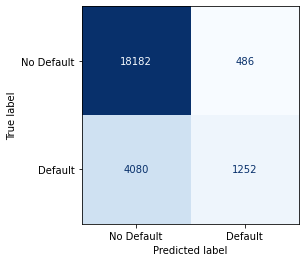

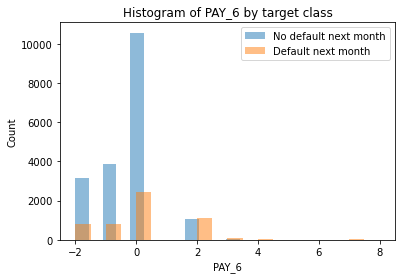

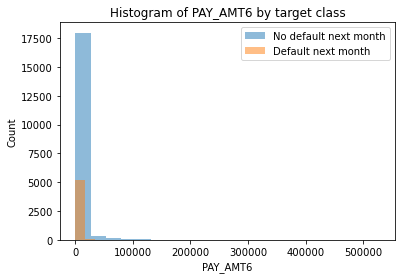

In [5]:
# from pandas_profiling import ProfileReport
# profile = ProfileReport(train_df, title = "Profile Report", explorative=True)
# profile

from sklearn.metrics import plot_confusion_matrix

pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train)
disp = plot_confusion_matrix(
    pipe,
    X_train,
    y_train,
    display_labels=["No Default", "Default"],
    values_format="d",
    cmap=plt.cm.Blues,
    colorbar=False,
);
plt.show()

negative_examples = train_df[train_df["default.payment.next.month"] == 0]
positive_examples = train_df[train_df["default.payment.next.month"] == 1]

# feature_list = list(train_df.columns)
# feature_list.remove('default.payment.next.month')
   
feature_list = ["PAY_6", "PAY_AMT6"]

for i in feature_list:
    plt.hist(negative_examples[i], bins = 20, alpha = 0.5, label = "No default next month")
    plt.hist(positive_examples[i], bins = 20, alpha = 0.5, label = "Default next month")
    plt.legend(loc = "upper right")
    plt.xlabel(i)
    plt.ylabel("Count")
    plt.title("Histogram of %s by target class" %i)
    plt.show()

**Confusion Matrix: We can see that there is a class imbalance occuring where there are more "no default" labels when compared to default labels. This means that we should use other scoring methods to check for model performance**
**PAY_6 Histogram: histogram of PAY_6 with the target class represented by the color. We can see that people who have missed their payments for more months are more likely to default.**
\
**PAY_AMT6 Histogram: histogram of PAY_6 with the target class represented by the color. We can see that people who make smaller payments are more likely to default.**

<br><br>

## (Optional) 4. Feature engineering <a name="4"></a>
<hr>
rubric={points:1}

**Your tasks:**

1. Carry out feature engineering. In other words, extract new features relevant for the problem and work with your new feature set in the following exercises. You may have to go back and forth between feature engineering and preprocessing. 

In [6]:
# from sklearn.feature_selection import SequentialFeatureSelector

# pipe_forward = make_pipeline(
#     StandardScaler(),
#     SequentialFeatureSelector(
#         LogisticRegression(max_iter=200), direction="forward"
#     ),
#     RandomForestClassifier(n_estimators=50, random_state=42),
# )
# pd.DataFrame(cross_validate(pipe_forward, X_train, y_train, return_train_score=True)).mean()

<br><br>

## 5. Preprocessing and transformations <a name="5"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Identify different feature types and the transformations you would apply on each feature type. 
2. Define a column transformer, if necessary. 

In [7]:
# Code from lecture 11 used
# for i in X_train.columns:
#     print(train_df[i].unique())


numeric_features = ["LIMIT_BAL", "AGE", "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6",
    "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6",
    "EDUCATION", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]
categorical_features = ["MARRIAGE"]
ordinal_features = []
binary_features = ["SEX"]
passthrough_features = []
drop_features = []
target = "default.payment.next.month"

numeric_transformer = make_pipeline(StandardScaler())

categorical_transformer = make_pipeline(
    OneHotEncoder(handle_unknown="ignore", sparse=False),
)

binary_transformer = make_pipeline(
    OneHotEncoder(drop="if_binary", dtype=int),
)

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (binary_transformer, binary_features),
    (categorical_transformer, categorical_features),
    ("drop", drop_features),
)


<br><br>

## 6. Baseline model <a name="6"></a>
<hr>

rubric={points:2}

**Your tasks:**
1. Try `scikit-learn`'s baseline model and report results.

In [8]:
#from Lecture:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [9]:
results_dic = {}
scoring = [
         "accuracy",
         "f1",
         "recall",
         "precision",
 ]
dummy = DummyClassifier()

results_dic["dummy"] = mean_std_cross_val_scores(dummy, X_train, y_train, return_train_score=True, scoring = scoring)
pd.DataFrame(results_dic)


C:\Users\Johnn\miniconda3\envs\cpsc330\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Johnn\miniconda3\envs\cpsc330\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Johnn\miniconda3\envs\cpsc330\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Johnn\miniconda3\envs\cpsc330\lib\site-packages\sklearn\metrics\_cl

,dummy
fit_time,0.005 (+/- 0.001)
score_time,0.007 (+/- 0.002)
test_accuracy,0.778 (+/- 0.000)
train_accuracy,0.778 (+/- 0.000)
test_f1,0.000 (+/- 0.000)
train_f1,0.000 (+/- 0.000)
test_recall,0.000 (+/- 0.000)
train_recall,0.000 (+/- 0.000)
test_precision,0.000 (+/- 0.000)
train_precision,0.000 (+/- 0.000)


<br><br>

## 7. Linear models <a name="7"></a>
<hr>
rubric={points:12}

**Your tasks:**

1. Try logistic regression as a first real attempt. 
2. Carry out hyperparameter tuning to explore different values for the complexity hyperparameter `C`. 
3. Report validation scores along with standard deviation. 
4. Summarize your results.

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
pipe_lr = make_pipeline(
    preprocessor,
    LogisticRegression(max_iter = 200)
)

results_dic["default_LR"] = mean_std_cross_val_scores(pipe_lr, X_train, y_train, return_train_score=True, scoring = scoring)
pd.DataFrame(results_dic)

,dummy,default_LR
fit_time,0.005 (+/- 0.001),0.448 (+/- 0.085)
score_time,0.007 (+/- 0.002),0.034 (+/- 0.015)
test_accuracy,0.778 (+/- 0.000),0.810 (+/- 0.005)
train_accuracy,0.778 (+/- 0.000),0.810 (+/- 0.001)
test_f1,0.000 (+/- 0.000),0.354 (+/- 0.024)
train_f1,0.000 (+/- 0.000),0.356 (+/- 0.011)
test_recall,0.000 (+/- 0.000),0.235 (+/- 0.019)
train_recall,0.000 (+/- 0.000),0.237 (+/- 0.009)
test_precision,0.000 (+/- 0.000),0.721 (+/- 0.031)
train_precision,0.000 (+/- 0.000),0.720 (+/- 0.005)


<br><br>

In [11]:
param_grid = {
    "logisticregression__C": np.logspace(-10, 5, 20)
}
random_search = RandomizedSearchCV(pipe_lr, param_distributions=param_grid, n_jobs=-1, n_iter=10, cv=5, random_state=123)
random_search.fit(X_train, y_train)
print(random_search.best_score_)
print(random_search.best_params_)

0.8097916666666667
{'logisticregression__C': 2636.6508987303555}


In [12]:
pipe_bestlr = make_pipeline(
    preprocessor,
    LogisticRegression(C = random_search.best_params_["logisticregression__C"], max_iter = 200)
)
results_dic["best_LR"] = mean_std_cross_val_scores(pipe_bestlr, X_train, y_train, return_train_score=True, scoring = scoring)
pd.DataFrame(results_dic)

,dummy,default_LR,best_LR
fit_time,0.005 (+/- 0.001),0.448 (+/- 0.085),0.276 (+/- 0.097)
score_time,0.007 (+/- 0.002),0.034 (+/- 0.015),0.024 (+/- 0.010)
test_accuracy,0.778 (+/- 0.000),0.810 (+/- 0.005),0.810 (+/- 0.005)
train_accuracy,0.778 (+/- 0.000),0.810 (+/- 0.001),0.810 (+/- 0.002)
test_f1,0.000 (+/- 0.000),0.354 (+/- 0.024),0.354 (+/- 0.024)
train_f1,0.000 (+/- 0.000),0.356 (+/- 0.011),0.356 (+/- 0.011)
test_recall,0.000 (+/- 0.000),0.235 (+/- 0.019),0.235 (+/- 0.019)
train_recall,0.000 (+/- 0.000),0.237 (+/- 0.009),0.237 (+/- 0.009)
test_precision,0.000 (+/- 0.000),0.721 (+/- 0.031),0.721 (+/- 0.031)
train_precision,0.000 (+/- 0.000),0.720 (+/- 0.005),0.720 (+/- 0.005)


**The logistic regression model performed slightly better than the dummy model. Additionally, the default C for LR had the same performance as the optimized C. In LR, there is a relatively higher precision than recall which means that a large portion of the positive predicted results are actually positive. However, low train and test recall means that a low amount of true positives were identified.**

## 8. Different classifiers <a name="8"></a>
<hr>
rubric={points:15}

**Your tasks:**
1. Try at least 3 other models aside from logistic regression. At least one of these models should be a tree-based ensemble model (e.g., lgbm, random forest, xgboost). 
2. Summarize your results. Can you beat logistic regression? 

In [13]:
#Code from lecture 11 used
from lightgbm.sklearn import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

pipe_dt = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=123))
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(random_state=123))
pipe_xgb = make_pipeline(
    preprocessor, XGBClassifier(random_state=123, eval_metric="logloss", verbosity=0)
)
pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(random_state=123))

classifiers = {
    "decision tree": pipe_dt,
    "random forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
}


In [14]:
import warnings

warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [15]:
for (name, model) in classifiers.items():
    results_dic[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring=scoring
    )

In [16]:
pd.DataFrame(results_dic)

,dummy,default_LR,best_LR,decision tree,random forest,XGBoost,LightGBM
fit_time,0.005 (+/- 0.001),0.448 (+/- 0.085),0.276 (+/- 0.097),0.786 (+/- 0.152),6.547 (+/- 0.685),2.314 (+/- 0.035),0.356 (+/- 0.036)
score_time,0.007 (+/- 0.002),0.034 (+/- 0.015),0.024 (+/- 0.010),0.045 (+/- 0.022),0.143 (+/- 0.031),0.033 (+/- 0.004),0.043 (+/- 0.001)
test_accuracy,0.778 (+/- 0.000),0.810 (+/- 0.005),0.810 (+/- 0.005),0.726 (+/- 0.003),0.815 (+/- 0.005),0.812 (+/- 0.006),0.819 (+/- 0.005)
train_accuracy,0.778 (+/- 0.000),0.810 (+/- 0.001),0.810 (+/- 0.002),0.999 (+/- 0.000),0.999 (+/- 0.000),0.894 (+/- 0.004),0.849 (+/- 0.002)
test_f1,0.000 (+/- 0.000),0.354 (+/- 0.024),0.354 (+/- 0.024),0.402 (+/- 0.012),0.468 (+/- 0.021),0.462 (+/- 0.022),0.476 (+/- 0.018)
train_f1,0.000 (+/- 0.000),0.356 (+/- 0.011),0.356 (+/- 0.011),0.999 (+/- 0.000),0.999 (+/- 0.000),0.713 (+/- 0.012),0.565 (+/- 0.007)
test_recall,0.000 (+/- 0.000),0.235 (+/- 0.019),0.235 (+/- 0.019),0.415 (+/- 0.018),0.367 (+/- 0.023),0.363 (+/- 0.022),0.370 (+/- 0.019)
train_recall,0.000 (+/- 0.000),0.237 (+/- 0.009),0.237 (+/- 0.009),0.997 (+/- 0.001),0.998 (+/- 0.000),0.590 (+/- 0.012),0.441 (+/- 0.008)
test_precision,0.000 (+/- 0.000),0.721 (+/- 0.031),0.721 (+/- 0.031),0.390 (+/- 0.008),0.648 (+/- 0.018),0.636 (+/- 0.021),0.667 (+/- 0.019)
train_precision,0.000 (+/- 0.000),0.720 (+/- 0.005),0.720 (+/- 0.005),1.000 (+/- 0.000),0.999 (+/- 0.000),0.900 (+/- 0.010),0.788 (+/- 0.003)


**The ensemble models (random forest, XGBoost, and LightGBM) yielded higher validation accuracy, higher validation F1 when compared to the logistic regression model. However, the improvement in validation accuracy is relatively small (less than 1% better). Large improvement in F1 (>0.1) scores can also be seen in ensemble models.**

<br><br>

## (Optional) 9. Feature selection <a name="9"></a>
<hr>
rubric={points:1}

**Your tasks:**

Make some attempts to select relevant features. You may try `RFECV` or forward selection. Do the results improve with feature selection? Summarize your results. If you see improvements in the results, keep feature selection in your pipeline. If not, you may abandon it in the next exercises. 

<br><br>

## 10. Hyperparameter optimization <a name="10"></a>
<hr>
rubric={points:15}

**Your tasks:**

Make some attempts to optimize hyperparameters for the models you've tried and summarize your results. You may pick one of the best performing models from the previous exercise and tune hyperparameters only for that model. You may use `sklearn`'s methods for hyperparameter optimization or fancier Bayesian optimization methods. 
  - [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
  - [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize)

**LightGBM will be used as it yielded the highest validation F1 and accuracy scores.**

In [17]:
param_grid = {
    "lgbmclassifier__learning_rate": np.logspace(-2, 1, 5),
    "lgbmclassifier__n_estimators": range(70,120),
}

pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(random_state=123))

# lgbm = LGBMClassifier(random_state=123)
# lgbm.get_params().keys()

random_search = RandomizedSearchCV(pipe_lgbm, param_distributions=param_grid, n_jobs=-1, n_iter=20, cv=5, random_state=1)
random_search.fit(X_train, y_train)

print(random_search.best_score_)
print(random_search.best_params_)

0.8214166666666667
{'lgbmclassifier__n_estimators': 98, 'lgbmclassifier__learning_rate': 0.05623413251903491}


In [18]:
pipe_bestlgbm = make_pipeline(
    preprocessor,
    LGBMClassifier(n_estimators = random_search.best_params_["lgbmclassifier__n_estimators"],
                       learning_rate = random_search.best_params_["lgbmclassifier__learning_rate"]
                  )
)
results_dic["best_LGBM"] = mean_std_cross_val_scores(pipe_bestlgbm, X_train, y_train, return_train_score=True, scoring = scoring)
pd.DataFrame(results_dic)

,dummy,default_LR,best_LR,decision tree,random forest,XGBoost,LightGBM,best_LGBM
fit_time,0.005 (+/- 0.001),0.448 (+/- 0.085),0.276 (+/- 0.097),0.786 (+/- 0.152),6.547 (+/- 0.685),2.314 (+/- 0.035),0.356 (+/- 0.036),0.360 (+/- 0.013)
score_time,0.007 (+/- 0.002),0.034 (+/- 0.015),0.024 (+/- 0.010),0.045 (+/- 0.022),0.143 (+/- 0.031),0.033 (+/- 0.004),0.043 (+/- 0.001),0.043 (+/- 0.001)
test_accuracy,0.778 (+/- 0.000),0.810 (+/- 0.005),0.810 (+/- 0.005),0.726 (+/- 0.003),0.815 (+/- 0.005),0.812 (+/- 0.006),0.819 (+/- 0.005),0.821 (+/- 0.005)
train_accuracy,0.778 (+/- 0.000),0.810 (+/- 0.001),0.810 (+/- 0.002),0.999 (+/- 0.000),0.999 (+/- 0.000),0.894 (+/- 0.004),0.849 (+/- 0.002),0.836 (+/- 0.002)
test_f1,0.000 (+/- 0.000),0.354 (+/- 0.024),0.354 (+/- 0.024),0.402 (+/- 0.012),0.468 (+/- 0.021),0.462 (+/- 0.022),0.476 (+/- 0.018),0.480 (+/- 0.017)
train_f1,0.000 (+/- 0.000),0.356 (+/- 0.011),0.356 (+/- 0.011),0.999 (+/- 0.000),0.999 (+/- 0.000),0.713 (+/- 0.012),0.565 (+/- 0.007),0.524 (+/- 0.008)
test_recall,0.000 (+/- 0.000),0.235 (+/- 0.019),0.235 (+/- 0.019),0.415 (+/- 0.018),0.367 (+/- 0.023),0.363 (+/- 0.022),0.370 (+/- 0.019),0.371 (+/- 0.016)
train_recall,0.000 (+/- 0.000),0.237 (+/- 0.009),0.237 (+/- 0.009),0.997 (+/- 0.001),0.998 (+/- 0.000),0.590 (+/- 0.012),0.441 (+/- 0.008),0.407 (+/- 0.008)
test_precision,0.000 (+/- 0.000),0.721 (+/- 0.031),0.721 (+/- 0.031),0.390 (+/- 0.008),0.648 (+/- 0.018),0.636 (+/- 0.021),0.667 (+/- 0.019),0.680 (+/- 0.022)
train_precision,0.000 (+/- 0.000),0.720 (+/- 0.005),0.720 (+/- 0.005),1.000 (+/- 0.000),0.999 (+/- 0.000),0.900 (+/- 0.010),0.788 (+/- 0.003),0.736 (+/- 0.008)


<br><br>

## 11. Interpretation and feature importances <a name="1"></a>
<hr>
rubric={points:15}

**Your tasks:**

1. Use the methods we saw in class (e.g., `eli5`, `shap`) (or any other methods of your choice) to explain feature importances of one of the best performing models. Summarize your observations. 

In [19]:
import eli5
pipe_bestlgbm.fit(X_train, y_train)

ohe_feature_names = (
    pipe_bestlgbm.named_steps["columntransformer"]
    .named_transformers_["pipeline-3"]
    .named_steps["onehotencoder"]
    .get_feature_names()
    .tolist()
)

feature_names = numeric_features + ohe_feature_names + binary_features

pipe_bestlgbm.fit(X_train, y_train)

eli5.explain_weights(
     pipe_bestlgbm.named_steps["lgbmclassifier"], feature_names = feature_names
)


Weight,Feature
0.4739,PAY_0
0.0608,PAY_2
0.0481,PAY_AMT2
0.0443,LIMIT_BAL
0.0394,BILL_AMT1
0.0286,PAY_AMT1
0.0259,PAY_AMT3
0.0258,PAY_3
0.0256,PAY_AMT4
0.0252,AGE


**PAY_0 seemed to have the highest weight (0.4739) in predicting the target result. This means the the repayment status of the person in September of 2005 is the largest indicator for whether someone will default next month. Additionally, PAY_0 and PAY_2 takes up over 50% of the weight in predict the target. This means that overall, The Pay_# features are the most important when it comes to determining the default status of a person.**

<br><br>

## 12. Results on the test set <a name="12"></a>
<hr>

rubric={points:5}

**Your tasks:**

1. Try your best performing model on the test data and report test scores. 
2. Do the test scores agree with the validation scores from before? To what extent do you trust your results? Do you think you've had issues with optimization bias? 

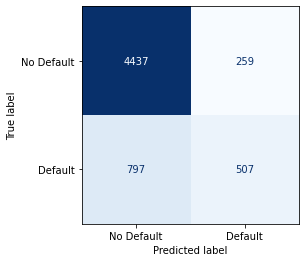

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      4696
           1       0.66      0.39      0.49      1304

    accuracy                           0.82      6000
   macro avg       0.75      0.67      0.69      6000
weighted avg       0.81      0.82      0.81      6000



In [20]:
pipe_bestlgbm.fit(X_train, y_train)
prediction = pipe_bestlgbm.predict(X_test)
pipe_bestlgbm.score(X_test, y_test)
disp = plot_confusion_matrix(
    pipe_bestlgbm,
    X_test,
    y_test,
    display_labels=["No Default", "Default"],
    values_format="d",
    cmap=plt.cm.Blues,
    colorbar=False,
);
plt.show()

print(classification_report(y_test,prediction))


**The testing score performed better than the validation score. Although there is only a minor improvement in prediction when comparing the dummy classifer to the best model, I would trust my results as the testing scores are consistent with the validation scores. I don't believe I have issues with optimization bias because the model does not appear to be over or underfitting.**

## (Optional) 13. Explaining predictions 
rubric={points:1}

**Your tasks**

1. Take one or two test predictions and explain them with SHAP force plots.  

<br><br>

## 14. Summary of results <a name="13"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Report your final test score along with the metric you used. 
2. Write concluding remarks.
3. Discuss other ideas that you did not try but could potentially improve the performance/interpretability . 

In [21]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      4696
           1       0.66      0.39      0.49      1304

    accuracy                           0.82      6000
   macro avg       0.75      0.67      0.69      6000
weighted avg       0.81      0.82      0.81      6000



**The final F-1 score achieved from the model is 0.49. Additionally, this model yielded an accuracy of 0.82. There are multiple things that can be performed to improve performance and interpretation. For example, using SHAP force plots would be good in visualizing the importance of different features. Additionally, there appeared to be some features that are used to describe similar things and they can be modified using feature engineering to improve the feature for the model. To conclude, due to the relatively weak performance of the model and additional measures that can be taken to improve the quality of the features, more can be done if this model were to be employed in real data to get better results.**

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 